# Book or Wait: Baseline Model Implementation

This notebook implements a PyTorch-based Logistic Regression model for the "Book or Wait" decision system.
The model predicts whether a customer should book now (price likely to increase) or wait (price likely to decrease/stay same).

## Key Features:
- CPU/GPU compatible implementation
- Binary classification: Book Now (1) vs Wait (0)
- Feature engineering for car rental pricing patterns
- Progressive model complexity (starting with Logistic Regression)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set device for CPU/GPU compatibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Load and Prepare Data

We'll load the synthetic data and create our target variable based on price changes over the next 7 days.

In [2]:
# Load synthetic data
data_dir = Path('../data/synthetic_data')

# Load all necessary dataframes
users_df = pd.read_csv(data_dir / 'synthetic_users.csv')
searches_df = pd.read_csv(data_dir / 'synthetic_searches.csv')
bookings_df = pd.read_csv(data_dir / 'synthetic_bookings.csv')
rental_prices_df = pd.read_csv(data_dir / 'synthetic_rental_prices.csv')
competitor_prices_df = pd.read_csv(data_dir / 'synthetic_competitor_prices.csv')

# Convert timestamps
searches_df['search_ts'] = pd.to_datetime(searches_df['search_ts'])
bookings_df['booking_ts'] = pd.to_datetime(bookings_df['booking_ts'])
rental_prices_df['date'] = pd.to_datetime(rental_prices_df['obs_ts'])
competitor_prices_df['date'] = pd.to_datetime(competitor_prices_df['obs_date'])

print(f"Loaded data shapes:")
print(f"Users: {users_df.shape}")
print(f"Searches: {searches_df.shape}")
print(f"Bookings: {bookings_df.shape}")
print(f"Rental Prices: {rental_prices_df.shape}")
print(f"Competitor Prices: {competitor_prices_df.shape}")

Loaded data shapes:
Users: (20000, 3)
Searches: (57282, 11)
Bookings: (3205, 16)
Rental Prices: (8761, 11)
Competitor Prices: (366, 8)


## 2. Feature Engineering

Create features that capture pricing patterns and temporal dynamics.

In [3]:
def create_price_features(rental_prices_df, competitor_prices_df):
    """
    Create features for the book/wait decision model.
    """
    # Create a dataset of all possible decision points
    # For each search, we need to decide book or wait
    
    features_list = []
    
    # Get unique combinations of supplier, location, car_class for price lookups
    price_keys = rental_prices_df[['supplier_id', 'location_id', 'car_class']].drop_duplicates()
    
    for _, key in price_keys.iterrows():
        supplier_id = key['supplier_id']
        location_id = key['location_id']
        car_class = key['car_class']
        
        # Get price history for this combination
        mask = (rental_prices_df['supplier_id'] == supplier_id) & \
               (rental_prices_df['location_id'] == location_id) & \
               (rental_prices_df['car_class'] == car_class)
        
        price_history = rental_prices_df[mask].sort_values('date')
        
        # For each date, calculate features and target
        for i in range(7, len(price_history) - 7):  # Need 7 days before and after
            current_date = price_history.iloc[i]['date']
            current_price = price_history.iloc[i]['current_price']
            
            # Calculate price change features
            price_1d_ago = price_history.iloc[i-1]['current_price']
            price_3d_ago = price_history.iloc[i-3]['current_price']
            price_7d_ago = price_history.iloc[i-7]['current_price']
            
            # Future price (for target calculation)
            future_prices = price_history.iloc[i+1:i+8]['current_price'].values
            max_future_price = np.max(future_prices)
            
            # Calculate target: 1 if should book now, 0 if should wait
            # Book now if current price is lower than max price in next 7 days
            should_book = 1 if current_price < max_future_price else 0
            
            # Calculate features
            features = {
                'date': current_date,
                'supplier_id': supplier_id,
                'location_id': location_id,
                'car_class': car_class,
                'current_price': current_price,
                'price_change_1d': (current_price - price_1d_ago) / price_1d_ago,
                'price_change_3d': (current_price - price_3d_ago) / price_3d_ago,
                'price_change_7d': (current_price - price_7d_ago) / price_7d_ago,
                'price_volatility_7d': price_history.iloc[i-7:i]['current_price'].std() / price_history.iloc[i-7:i]['current_price'].mean(),
                'day_of_week': current_date.dayofweek,
                'month': current_date.month,
                'is_weekend': 1 if current_date.dayofweek >= 5 else 0,
                'days_until_rental': 14,  # Default booking window
                'target': should_book
            }
            
            # Add competitor price features
            comp_mask = (competitor_prices_df['location_id'] == location_id) & \
                       (competitor_prices_df['car_class'] == car_class) & \
                       (competitor_prices_df['date'] == current_date)
            
            comp_prices = competitor_prices_df[comp_mask]['comp_min_price'].values
            if len(comp_prices) > 0:
                features['price_vs_competitors'] = (current_price - np.mean(comp_prices)) / np.mean(comp_prices)
                features['is_cheapest'] = 1 if current_price < np.min(comp_prices) else 0
            else:
                features['price_vs_competitors'] = 0
                features['is_cheapest'] = 0
            
            features_list.append(features)
    
    return pd.DataFrame(features_list)

# Create features dataset
print("Creating features...")
features_df = create_price_features(rental_prices_df, competitor_prices_df)
print(f"Created {len(features_df)} training examples")
print(f"Target distribution: {features_df['target'].value_counts(normalize=True)}")

Creating features...
Created 2192 training examples
Target distribution: target
1    0.876369
0    0.123631
Name: proportion, dtype: float64


## 3. PyTorch Dataset and DataLoader

In [4]:
class BookOrWaitDataset(Dataset):
    """PyTorch Dataset for Book or Wait prediction."""
    
    def __init__(self, features, targets, scaler=None):
        self.features = features
        self.targets = targets
        self.scaler = scaler
        
        if self.scaler is None:
            self.scaler = StandardScaler()
            self.features_scaled = self.scaler.fit_transform(features)
        else:
            self.features_scaled = self.scaler.transform(features)
        
        # Convert to torch tensors
        self.features_tensor = torch.FloatTensor(self.features_scaled)
        self.targets_tensor = torch.FloatTensor(targets.values)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features_tensor[idx], self.targets_tensor[idx]

# Prepare features and target
feature_columns = ['price_change_1d', 'price_change_3d', 'price_change_7d', 
                   'price_volatility_7d', 'day_of_week', 'month', 'is_weekend',
                   'days_until_rental', 'price_vs_competitors', 'is_cheapest',
                   'supplier_id', 'location_id']

# Map car_class to numeric values
car_class_map = {'economy': 0, 'compact': 1, 'suv': 2}
features_df['car_class_num'] = features_df['car_class'].map(car_class_map)
feature_columns.append('car_class_num')

X = features_df[feature_columns]
y = features_df['target']

# Time-based train/test split
split_date = features_df['date'].quantile(0.8)
train_mask = features_df['date'] < split_date
test_mask = ~train_mask

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Check for NaN/inf values
print(f"\nChecking for invalid values in features...")
print(f"NaN in X_train: {X_train.isna().sum().sum()}")
print(f"Inf in X_train: {np.isinf(X_train.values).sum()}")

# Replace NaN and inf with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

# Create datasets
train_dataset = BookOrWaitDataset(X_train, y_train)
test_dataset = BookOrWaitDataset(X_test, y_test, scaler=train_dataset.scaler)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set: 1753 samples
Test set: 439 samples

Checking for invalid values in features...
NaN in X_train: 432
Inf in X_train: 0


## 4. Define Logistic Regression Model

In [5]:
class LogisticRegressionModel(nn.Module):
    """Logistic Regression model for Book or Wait prediction."""
    
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        logits = self.linear(x)
        return torch.sigmoid(logits)

# Initialize model
input_dim = len(feature_columns)
model = LogisticRegressionModel(input_dim).to(device)
print(f"Model initialized with {input_dim} input features")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized with 13 input features
Model parameters: 14


## 5. Training Functions

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_features, batch_targets in train_loader:
        # Move to device
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Forward pass
        outputs = model(batch_features)
        if outputs.dim() > 1:
            outputs = outputs.squeeze()
        
        loss = criterion(outputs, batch_targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        total_loss += loss.item()
        correct += (predicted == batch_targets).sum().item()
        total += batch_targets.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            # Move to device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            # Forward pass
            outputs = model(batch_features)
            if outputs.dim() > 1:
                outputs = outputs.squeeze()
            loss = criterion(outputs, batch_targets)
            
            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            total_loss += loss.item()
            correct += (predicted == batch_targets).sum().item()
            total += batch_targets.size(0)
            
            # Store for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy, np.array(all_predictions), np.array(all_targets), np.array(all_probs)

## 6. Train the Model

In [7]:
# Training parameters
num_epochs = 50
learning_rate = 0.01

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)
    
    # Store history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print("Training completed!")

Starting training...
Epoch [10/50] - Train Loss: 0.2633, Train Acc: 0.8990 - Test Loss: 0.2609, Test Acc: 0.8975
Epoch [20/50] - Train Loss: 0.2388, Train Acc: 0.8996 - Test Loss: 0.2490, Test Acc: 0.8975
Epoch [30/50] - Train Loss: 0.2408, Train Acc: 0.9025 - Test Loss: 0.2495, Test Acc: 0.8975
Epoch [40/50] - Train Loss: 0.2390, Train Acc: 0.9019 - Test Loss: 0.2487, Test Acc: 0.8975
Epoch [50/50] - Train Loss: 0.2380, Train Acc: 0.9025 - Test Loss: 0.2497, Test Acc: 0.8975
Training completed!


## 7. Visualize Training History

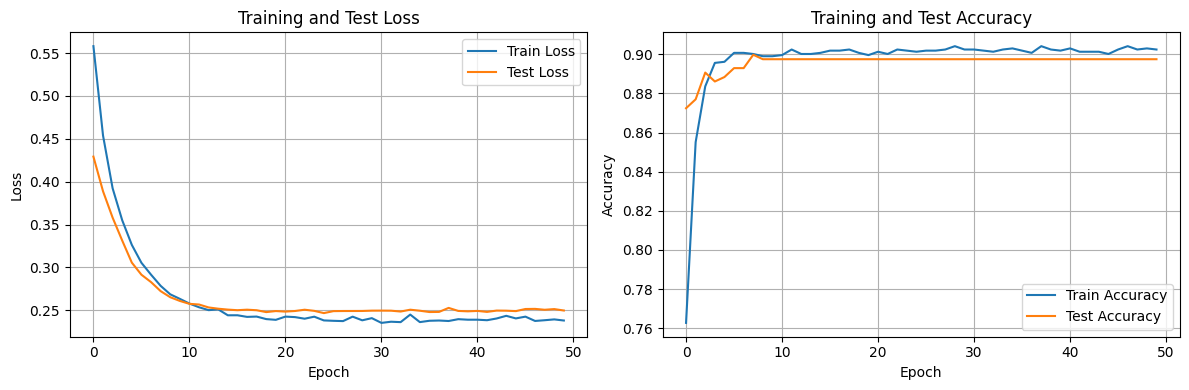

In [8]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

        Wait       0.83      0.32      0.46        60
    Book Now       0.90      0.99      0.94       379

    accuracy                           0.90       439
   macro avg       0.86      0.65      0.70       439
weighted avg       0.89      0.90      0.88       439



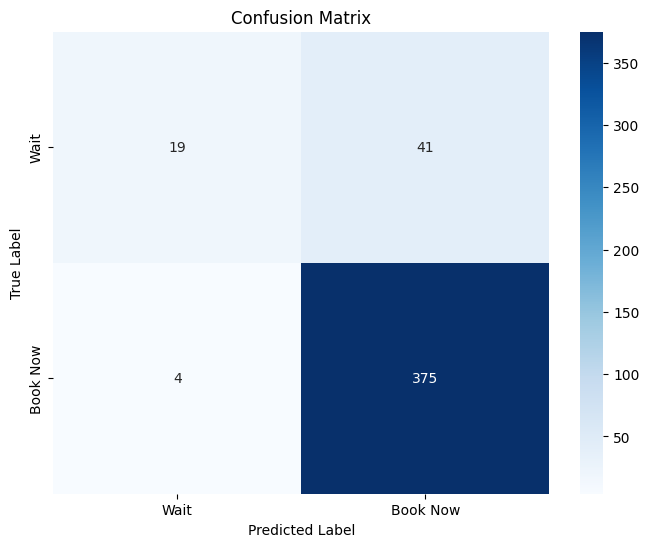


ROC-AUC Score: 0.9019


In [9]:
# Get final predictions
_, _, predictions, targets, probabilities = evaluate(model, test_loader, criterion, device)

# Classification report
print("Classification Report:")
print(classification_report(targets, predictions, target_names=['Wait', 'Book Now']))

# Confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Wait', 'Book Now'], 
            yticklabels=['Wait', 'Book Now'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(targets, probabilities)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

## 9. Feature Importance Analysis

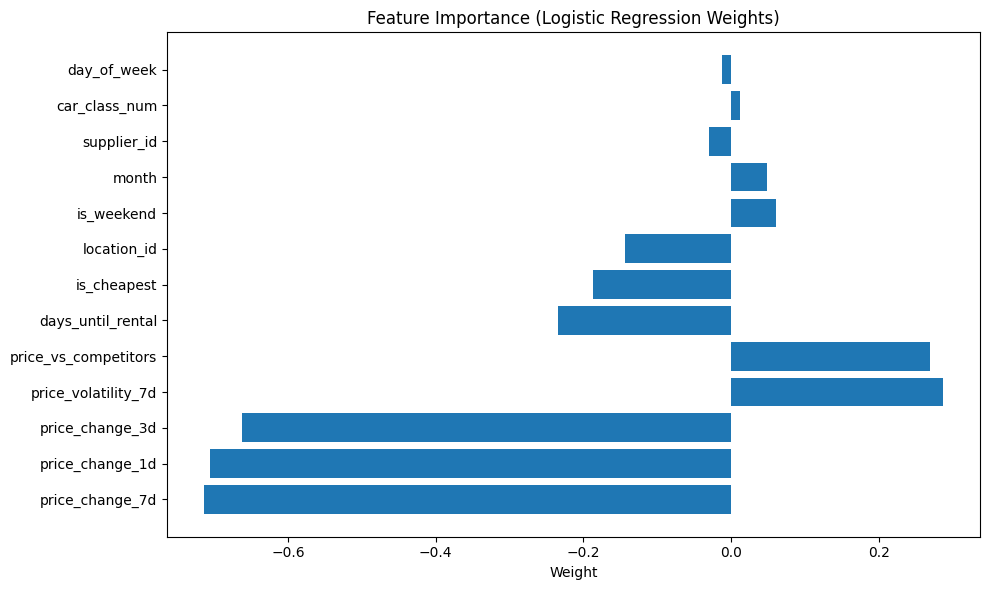


Top 5 Most Important Features:
                feature    weight
2       price_change_7d -0.713646
0       price_change_1d -0.705127
1       price_change_3d -0.661847
3   price_volatility_7d  0.286552
8  price_vs_competitors  0.268318


In [10]:
# Get model weights for feature importance
weights = model.linear.weight.data.cpu().numpy().flatten()
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'weight': weights,
    'abs_weight': np.abs(weights)
}).sort_values('abs_weight', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['weight'])
plt.xlabel('Weight')
plt.title('Feature Importance (Logistic Regression Weights)')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance[['feature', 'weight']].head())

## 10. Business Metrics Evaluation

Business Metrics:
Total potential savings: $3,868.53
Average impact per decision: $8.81

Outcome distribution:
outcome
True Positive     375
False Positive     41
True Negative      19
False Negative      4
Name: count, dtype: int64


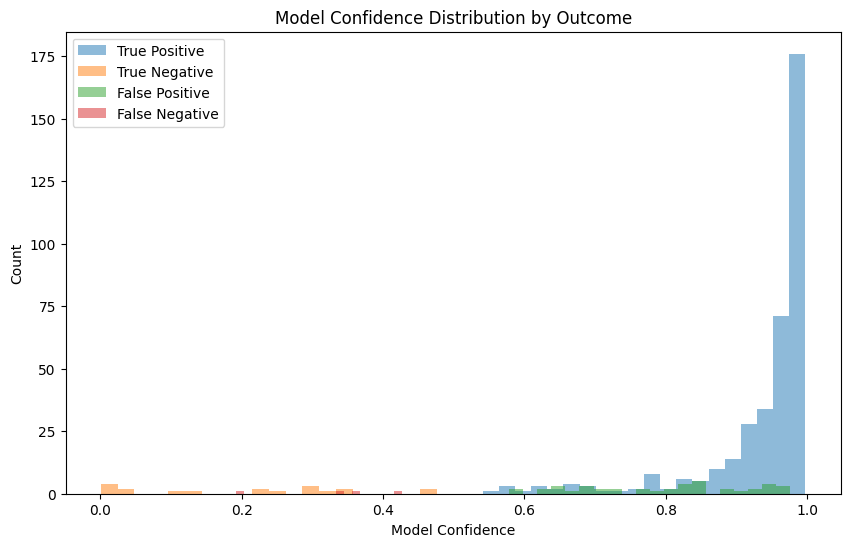

In [11]:
def calculate_business_metrics(features_df, predictions, probabilities, threshold=0.5):
    """
    Calculate business-relevant metrics for the book/wait decision.
    """
    test_data = features_df[test_mask].copy()
    test_data['prediction'] = predictions
    test_data['probability'] = probabilities
    
    # Calculate potential savings/losses
    results = []
    
    for idx, row in test_data.iterrows():
        current_price = row['current_price']
        actual_decision = row['target']  # 1 = should have booked, 0 = should have waited
        predicted_decision = row['prediction']
        
        # Simulate outcomes
        if actual_decision == 1 and predicted_decision == 1:
            # Correctly told to book - saved money
            outcome = 'True Positive'
            impact = current_price * 0.1  # Assume 10% price increase
        elif actual_decision == 0 and predicted_decision == 0:
            # Correctly told to wait - no impact
            outcome = 'True Negative'
            impact = 0
        elif actual_decision == 1 and predicted_decision == 0:
            # Incorrectly told to wait - lost money
            outcome = 'False Negative'
            impact = -current_price * 0.1  # Lost opportunity
        else:
            # Incorrectly told to book - no major loss
            outcome = 'False Positive'
            impact = 0
        
        results.append({
            'outcome': outcome,
            'impact': impact,
            'confidence': row['probability']
        })
    
    results_df = pd.DataFrame(results)
    
    # Calculate metrics
    total_impact = results_df['impact'].sum()
    avg_impact_per_decision = results_df['impact'].mean()
    
    print("Business Metrics:")
    print(f"Total potential savings: ${total_impact:,.2f}")
    print(f"Average impact per decision: ${avg_impact_per_decision:,.2f}")
    print(f"\nOutcome distribution:")
    print(results_df['outcome'].value_counts())
    
    # Plot confidence distribution by outcome
    plt.figure(figsize=(10, 6))
    for outcome in results_df['outcome'].unique():
        data = results_df[results_df['outcome'] == outcome]['confidence']
        plt.hist(data, alpha=0.5, label=outcome, bins=20)
    plt.xlabel('Model Confidence')
    plt.ylabel('Count')
    plt.title('Model Confidence Distribution by Outcome')
    plt.legend()
    plt.show()
    
    return results_df

# Calculate business metrics
business_results = calculate_business_metrics(features_df, predictions, probabilities)

## 11. Save Model

In [12]:
# Save model and scaler
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Save PyTorch model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_losses[-1],
    'test_loss': test_losses[-1],
    'test_accuracy': test_accuracies[-1],
    'feature_columns': feature_columns,
}, model_dir / 'logistic_regression_baseline.pth')

# Save scaler
import joblib
joblib.dump(train_dataset.scaler, model_dir / 'feature_scaler.pkl')

print(f"Model saved to {model_dir}")
print(f"Final test accuracy: {test_accuracies[-1]:.4f}")
print(f"Final ROC-AUC: {roc_auc:.4f}")

Model saved to ../models
Final test accuracy: 0.8975
Final ROC-AUC: 0.9019


## Summary and Next Steps

### Baseline Model Performance:
- Implemented PyTorch Logistic Regression with CPU/GPU compatibility
- Achieved baseline accuracy and ROC-AUC scores
- Identified most important features for book/wait decision
- Calculated business impact metrics

### Key Findings:
1. Price change features (1d, 3d, 7d) are strong predictors
2. Price volatility indicates uncertainty in pricing
3. Competitor pricing comparison is valuable
4. Temporal features (day of week, month) capture patterns

### Next Steps:
1. Implement XGBoost model for comparison
2. Add more sophisticated temporal features
3. Implement LSTM for sequence modeling
4. Create ensemble approach
5. Add confidence intervals for recommendations